In [1]:
import math
import numpy as np
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numba

import sympy


sys.path.append('../')

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

'0.4.4'

In [3]:
### MOMENTUM DISTRIBUTION EXAMPLE
QMAX = 10*qBohr # Global value for q0=qMax for wavelets

Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)

# # Read Fnlm from saved csv file...
fs2_csv = 'demo_fs2'
fs2 = vsdm.Fnlm(Qdict, f_type='fs2', use_gvar=False)
fs2.center_Z2 = True
fs2.importFnlm_csv('tools/demo/demo_fs2.csv')
print(fs2.basis)
print('t_eval:', fs2.t_eval)
print('nCoeffs = {}'.format(len(fs2.f_nlm.keys())))

### VELOCITY DISTRIBUTION EXAMPLE
# Model 4: a bunch of streams, not symmetric. 
# Including the halo component without vEsc.

VMAX = 820.*km_s #960.*km_s # Global value for v0=vMax for wavelets
Vdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)

"""Read from CSV"""
gX = vsdm.Fnlm(Vdict, f_type='gX', use_gvar=False)
gX.importFnlm_csv('tools/demo/SHM_v250.csv')
print(gX.basis)
print('t_eval:', gX.t_eval)
print('nCoeffs = {}'.format(len(gX.f_nlm.keys())))

{'u0': 37289.47137978341, 'type': 'wavelet', 'uMax': 37289.47137978341}
t_eval: 0.3364870548248291
nCoeffs = 114688
{'u0': 0.002735229759299781, 'type': 'wavelet', 'uMax': 0.002735229759299781}
t_eval: 0.07683110237121582
nCoeffs = 33928


In [4]:
"""Comprehensive mI calculation for larger list of DM masses:

Following the results from 'Convergence', use a smaller ellMax and nMax:
"""

#We copy-paste this from before.
QMAX = 10*qBohr # Global value for q0=qMax for wavelets
Qbasis = dict(u0=QMAX, type='wavelet', uMax=QMAX)

VMAX = 820.*km_s #960.*km_s # Global value for v0=vMax for wavelets
Vbasis = dict(u0=VMAX, type='wavelet', uMax=VMAX)


ellMax = 16
nvMax = 255
nqMax = 255


# ls10 = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
# p10 = [1, 10, 100]
#ls10 = [1]
#p10 = [10]
#mXlist = np.array([p*m for p in p10 for m in ls10])
# mXlist = mXlist[0:25]

"""Check the evaluation time for mcalI:"""
#ls10 = [1] # what I want is actually ls10 = [1,2,3,4,5,6,7,8,9]
#p10 = [1, 10, 100]
#mXlist = np.array([p*m for p in p10 for m in ls10])
mXlist = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12,15, 20, 30, 40, 50, 60, 70, 80, 90, 100])#np.array([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])

"""Check the evaluation time for mcalI:""" #This evaluates mI matrices if we need them, but we prefer to import them from hdf5
"""
mI = {}
modelsDM = []
t0 = time.time()
for a in [-4,-2,0,2,4]:
    for b in [0,2,4]:
        fn=(a,b)
        for mX in mXlist:
            modelsDM += [(mX, fn)]
            dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=4.03*eV)
            mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                    mI_shape=(ellMax+1, nvMax+1,nqMax+1),center_Z2=True, 
                                      use_gvar=False, do_mcalI=True)
            print('\t', (mX, fn), ": ", mI[(mX, fn)].t_eval)
tEvalI = time.time() - t0
print('tI avg:', tEvalI/len(modelsDM))
"""

'\nmI = {}\nmodelsDM = []\nt0 = time.time()\nfor a in [-4,-2,0,2,4]:\n    for b in [0,2,4]:\n        fn=(a,b)\n        for mX in mXlist:\n            modelsDM += [(mX, fn)]\n            dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=4.03*eV)\n            mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, \n                                    mI_shape=(ellMax+1, nvMax+1,nqMax+1),center_Z2=True, \n                                      use_gvar=False, do_mcalI=True)\n            print(\'\t\', (mX, fn), ": ", mI[(mX, fn)].t_eval)\ntEvalI = time.time() - t0\nprint(\'tI avg:\', tEvalI/len(modelsDM))\n'

In [5]:
# Let's import our mI matrices from hdf5 files created with julia. I need to manually fill those in.

mI = {}
modelsDM = []
for a in [-4,-2,0]:
    for b in [0]:
        fn = (a,b)
        for mX in mXlist:
            modelsDM += [(mX, fn)]
            dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=4.03*eV)
            mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                    mI_shape=(ellMax+1, nvMax+1,nqMax+1),center_Z2=True, 
                                      use_gvar=False, do_mcalI=False)
            mI[(mX, fn)].evaluated = True


            model = "4.030eV/" + "(" + str(mX) + ", " + str(a) + ", " + str(b) + ")"
            print(model)
            hdf5file = "/Users/pankajmunbodh/Desktop/Santa Cruz Physics2/DM-electron project (Tien-Tien)/out/TSB_julia.hdf5"
            with h5py.File(hdf5file,'r') as fhd5:
                mgroup = fhd5['mcalI/' + model]
                #print(mgroup)
                #print(mgroup.keys()) # optional: make sure dataset name is 'Ilvq'
                data_in = mgroup['Ilvq'][:] # read in the 3d array
                #print(data_in)
                mI[(mX,fn)].mcalI = data_in

                if mX==1:
                    mI[(mX, fn)].evaluated = False # for some reason, I need to EVALUATE this one because Julia just gives all zeros.
            
            
            
"""
dmModel_try = dict(mX=1*MeV, fdm_n=(-4,0), mSM=mElec, DeltaE=4.03*eV)
mII = vsdm.McalI(Vdict, Qdict, dmModel_try, 
                                    mI_shape=(ellMax+1, nvMax+1,nqMax+1),center_Z2=True, 
                                      use_gvar=False, do_mcalI=False)




model = "4.030eV/(1, -4, 0)"
hdf5file = "/Users/pankajmunbodh/Desktop/Santa Cruz Physics2/DM-electron project (Tien-Tien)/out/TSB_julia.hdf5"
with h5py.File(hdf5file,'r') as fhd5:
    mgroup = fhd5['mcalI/' + model]
    #print(mgroup)
    #print(mgroup.keys()) # optional: make sure dataset name is 'Ilvq'
    data_in = mgroup['Ilvq'][:] # read in the 3d array
    print(data_in)
    mII.mcalI = data_in
"""


4.030eV/(1, -4, 0)
4.030eV/(2, -4, 0)
4.030eV/(3, -4, 0)
4.030eV/(4, -4, 0)
4.030eV/(5, -4, 0)
4.030eV/(6, -4, 0)
4.030eV/(7, -4, 0)
4.030eV/(8, -4, 0)
4.030eV/(9, -4, 0)
4.030eV/(10, -4, 0)
4.030eV/(12, -4, 0)
4.030eV/(15, -4, 0)
4.030eV/(20, -4, 0)
4.030eV/(30, -4, 0)
4.030eV/(40, -4, 0)
4.030eV/(50, -4, 0)
4.030eV/(60, -4, 0)
4.030eV/(70, -4, 0)
4.030eV/(80, -4, 0)
4.030eV/(90, -4, 0)
4.030eV/(100, -4, 0)
4.030eV/(1, -2, 0)
4.030eV/(2, -2, 0)
4.030eV/(3, -2, 0)
4.030eV/(4, -2, 0)
4.030eV/(5, -2, 0)
4.030eV/(6, -2, 0)
4.030eV/(7, -2, 0)
4.030eV/(8, -2, 0)
4.030eV/(9, -2, 0)
4.030eV/(10, -2, 0)
4.030eV/(12, -2, 0)
4.030eV/(15, -2, 0)
4.030eV/(20, -2, 0)
4.030eV/(30, -2, 0)
4.030eV/(40, -2, 0)
4.030eV/(50, -2, 0)
4.030eV/(60, -2, 0)
4.030eV/(70, -2, 0)
4.030eV/(80, -2, 0)
4.030eV/(90, -2, 0)
4.030eV/(100, -2, 0)
4.030eV/(1, 0, 0)
4.030eV/(2, 0, 0)
4.030eV/(3, 0, 0)
4.030eV/(4, 0, 0)
4.030eV/(5, 0, 0)
4.030eV/(6, 0, 0)
4.030eV/(7, 0, 0)
4.030eV/(8, 0, 0)
4.030eV/(9, 0, 0)
4.030eV/(10, 0

'\ndmModel_try = dict(mX=1*MeV, fdm_n=(-4,0), mSM=mElec, DeltaE=4.03*eV)\nmII = vsdm.McalI(Vdict, Qdict, dmModel_try, \n                                    mI_shape=(ellMax+1, nvMax+1,nqMax+1),center_Z2=True, \n                                      use_gvar=False, do_mcalI=False)\n\n\n\n\nmodel = "4.030eV/(1, -4, 0)"\nhdf5file = "/Users/pankajmunbodh/Desktop/Santa Cruz Physics2/DM-electron project (Tien-Tien)/out/TSB_julia.hdf5"\nwith h5py.File(hdf5file,\'r\') as fhd5:\n    mgroup = fhd5[\'mcalI/\' + model]\n    #print(mgroup)\n    #print(mgroup.keys()) # optional: make sure dataset name is \'Ilvq\'\n    data_in = mgroup[\'Ilvq\'][:] # read in the 3d array\n    print(data_in)\n    mII.mcalI = data_in\n'

In [6]:
mI[1,(-4,0)].mcalI

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [7]:
### Quaternion rotation
# finding the rotation that moves a 'z hat' unit vector to point towards (theta, phi)

def getQ(theta, phi):
    axisphi = phi + np.pi/2 #stationary under R
    axR = theta/2 
    qr = np.cos(axR)
    qi = np.sin(axR) * np.cos(axisphi)
    qj = np.sin(axR) * np.sin(axisphi)
    qk = 0. 
    return quaternionic.array(qr, qi, qj, qk)

rotationlist = []
rotationarray = []
thetaphilist = []

thetas = np.loadtxt("thetas300.csv")
phis = np.loadtxt("phis300.csv")



for i in range(len(thetas)): # here len(thetas) gives the number of pixels (Healpix)
    theta = thetas[i]
    phi = phis[i]
    q = 1/getQ(theta, phi) 
    rotationlist += [q] 
    thetaphilist += [(theta, phi)]

wG = vsdm.WignerG(ellMax, rotations=rotationlist)

In [60]:
#rates = vsdm.RateCalc(gX, fs2, mI[(mX,fn)],use_gvar=False, sparse=False,lmod=2)
#mu_R_l = rates.mu_R_l(wG)     # gives rates for all rotations in rotationlist
#rate_R = mu_R_l.sum(axis=1)
#mu_all = mu_R_l
#rate_all = rate_R
#rate_angavg = rates.vecK[0] # the ell=0 component of vecK is the angular average
    

In [8]:
len(rate_all)

NameError: name 'rate_all' is not defined

In [8]:
t0 = time.time()
vsdm.RateCalc(gX, fs2, mI[(100,(-4,0))],use_gvar=False, sparse=False,lmod=2)
print(time.time()-t0)

0.4257051944732666


In [9]:
np.shape(mI[(100,(-4,0))].mcalI)

(17, 256, 256)

In [10]:
vsdm.RateCalc(gX, fs2, mI[(50,(-4,0))],use_gvar=False, sparse=False,lmod=2)

In [11]:
t0 = time.time()
rates={}
rates_norm = {}
for DM in mI.keys():
    print(DM)
    rate = vsdm.RateCalc(gX, fs2, mI[DM],use_gvar=False, sparse=False,lmod=2)
    mu_R_l = rate.mu_R_l(wG)     # gives rates for all rotations in rotationlist
    rate_R = mu_R_l.sum(axis=1)
    mu_all = mu_R_l
    rate_all = rate_R
    rate_angavg = rate.vecK[0]
    
    rates[DM]=rate_R

    rate_norm = rate_all/rate_angavg

    print(rate_angavg)

    rates_norm[DM] = rate_norm
print(time.time()-t0)

(1, (-4, 0))


/var/folders/xm/dgywcqjd46l1x_7k4knjbbxm0000gn/T/ipykernel_32591/1619611213.py:15: RuntimeWarning: invalid value encountered in divide
  rate_norm = rate_all/rate_angavg


0.0
(2, (-4, 0))
0.21680482616941507
(3, (-4, 0))
0.48148059071758026
(4, (-4, 0))
0.5798075356076299
(5, (-4, 0))
0.5949712898585034
(6, (-4, 0))
0.5771993855413383
(7, (-4, 0))
0.5478166135078685
(8, (-4, 0))
0.51556461415137
(9, (-4, 0))
0.4839870276920031
(10, (-4, 0))
0.45443842986616095
(12, (-4, 0))
0.40268366846767456
(15, (-4, 0))
0.3416849789807663
(20, (-4, 0))
0.27113082274030736
(30, (-4, 0))
0.19077362415446525
(40, (-4, 0))
0.14685992808543802
(50, (-4, 0))
0.11930638649071754
(60, (-4, 0))
0.1004333893533521
(70, (-4, 0))
0.08670539334525143
(80, (-4, 0))
0.07627401727279046
(90, (-4, 0))
0.06808044766491432
(100, (-4, 0))
0.06147499467221771
(1, (-2, 0))
0.0
(2, (-2, 0))
0.17747205910262395
(3, (-2, 0))
0.4280818670470682
(4, (-2, 0))
0.5325177181464195
(5, (-2, 0))
0.5543175406456855
(6, (-2, 0))
0.5414634528289385
(7, (-2, 0))
0.5156859893751076
(8, (-2, 0))
0.48619372383851844
(9, (-2, 0))
0.45682532591309505
(10, (-2, 0))
0.42910850243894877
(12, (-2, 0))
0.3802682

## Print rates

In [31]:
rates[1,(-4,0)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## I have my rates. Now let's do the minimization routine

In [41]:
# I want to exclude mX = 1 MeV from the fit because the rates are all zero. Redefine mXlist.
mXlist = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 12,15, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [42]:
# This will need to be rewritten later when we have more models.

list_a = [-4,-2,0] #[-4,-2,0,2,4]
list_b = [0] #[0,2,4]
    
N = len(list_a)*len(list_b) # number of models to consider.
def rate_mat(mX,R_obs):
    
    m = len(R_obs)  
    
    rate_mat = np.zeros((m,N)) # create rate_matrix of zeros.
    
    #Fill up rate_matrix
    count = 0
    for a in list_a:
        for b in list_b:
            #print(count)
            rate_mat[:,count] = rates[(mX,(a, b))][:m]
            count = count+1

    return rate_mat

# Performs SVD and finds pseudoinverse. Returns only pseudoinverse.
def pseudo_inv(M): 
    u,sigma,v_transpose =  np.linalg.svd(M, compute_uv=True, full_matrices=True)
    #print("The matrix Sigma is", sigma)
    sigma = 1/sigma # I need to find the pseudo-inverse of the diagonal sigma matrix by taking the reciprocal

    m = np.shape(M)[0] #dimensions of matrix M which is m by n.
    n = np.shape(M)[1] 
    
    sigma_mat = np.zeros((m, n), dtype=np.float64) # makes the m by n matrix out of the array.
    sigma_mat[:len(sigma), :len(sigma)] = np.diag(sigma)
    

    #print(np.shape(sigma_mat))
    #print(np.shape(v_transpose))
    #print(np.shape(u))

    
    
    return np.dot(np.dot(v_transpose.T, sigma_mat.T),u.T)  # I need to transpose the 1/sigma to get pseudoinverse of sigma.

def q_approx(d, R_obs, R): # only use when mu is very large, mu >> 100
    W_half = np.diag(R_obs**(-1/2))
    r_tilde = np.matmul(W_half,R_obs - np.matmul(R,d))
    #r_tilde = np.matmul(W_half,R_obs) - np.matmul(W_half,np.matmul(R,d))
    return np.linalg.norm(r_tilde)**2

def q_exact(d,R_obs,R):
    return np.sum((R_obs - np.matmul(R,d))**2/(np.matmul(R,d)))

In [120]:
from scipy.optimize import nnls, lsq_linear
def qd_star_nnls(mX, R_obs):
    R_mX = rate_mat(mX, R_obs)
    W_half = np.diag(R_obs**(-1/2))
    tilde_R_obs = np.matmul(W_half, R_obs)
    tilde_R_mX = np.matmul(W_half, R_mX)

    dstar = nnls(tilde_R_mX,tilde_R_obs)[0]

    return dstar,q_approx(dstar, R_obs, R_mX)

def qd_star_lsq_linear(mX,R_obs): # place bounds only on some variables.
    R_mX = rate_mat(mX, R_obs)
    W_half = np.diag(R_obs**(-1/2))
    tilde_R_obs = np.matmul(W_half, R_obs)
    tilde_R_mX = np.matmul(W_half, R_mX)

    bounds = (np.array([0,-np.inf,0]), np.array([np.inf,np.inf,np.inf]))
    
    sol = lsq_linear(tilde_R_mX,tilde_R_obs,bounds=bounds)

    #print(sol)

    if sol['success'] == True:
        dstar = sol['x']
    else:
        print("No convergence. Exit.")

    #print(dstar)

    return dstar, q_approx(dstar, R_obs, R_mX)
    

In [121]:
qd_star_lsq_linear(10, R_obs_modelC_300[0])

(array([2.12514443e+01, 2.08035606e+02, 1.01155841e-08]), 342.38476746434304)

In [122]:

#Function that gives q(d_star) where d_star is best-fit point.
def qd_star(mX,R_obs):
    R_mX = rate_mat(mX, R_obs)
    W_half = np.diag(R_obs**(-1/2))
    tilde_R_obs = np.matmul(W_half, R_obs)
    tilde_R_mX = np.matmul(W_half, R_mX)
    tilde_pseudo_inverse_mX = pseudo_inv(tilde_R_mX)

    dstar = np.dot(tilde_pseudo_inverse_mX, tilde_R_obs)

    return dstar,q_approx(dstar, R_obs, R_mX)
# This function is not really necessary. It gives the coordinates in (model) d-space corresponding to the semi-axes
# of the ellipsoid satisfying q(d) = constant
def q_contour_pts(constant, mX,R_obs):
    R_mX = rate_mat(mX, R_obs)
    
    W_half = np.diag(R_obs**(-1/2))
    tilde_R_obs = np.matmul(W_half, R_obs)
    tilde_R_mX = np.matmul(W_half, R_mX)
    tilde_pseudo_inverse_mX = pseudo_inv(tilde_R_mX)

    d_star_mX = np.dot(tilde_pseudo_inverse_mX, tilde_R_obs)
    qmin = q_approx(d_star_mX, R_obs, R_mX)
    print("The value of q(dstar) is", qmin)
    constant = constant - qmin # this is crucial. Although intuitive, I don't follow the logic.
    if constant < 0:
        raise Exception("You cannot have contours q(d) < q(d_star). Please adjust your constant.")
    
    u_tilde,sigma_tilde,v_tilde_transpose = np.linalg.svd(np.sqrt(constant)*tilde_pseudo_inverse_mX)

    

    

    print(sigma_tilde)

    d_semi_axes = np.zeros((len(sigma_tilde), len(u_tilde[0])))# semi-axes of ellipsoid corresponding to q_approx = constant in d-model space
    #note that these are in d-space which is shifted and rotated from the ellipsoid center.
    
    for i in range(len(sigma_tilde)):
        d_semi_axis = (np.dot(tilde_pseudo_inverse_mX, tilde_R_obs) + sigma_tilde[i]*u_tilde[:,i])
        
        d_semi_axes[i,:] = d_semi_axis
        print(q_approx(d_semi_axis, R_obs, R_mX)) # check if q_approx = constant as required.

    return d_semi_axes


# This function allows us to generate points on the ellipsoid.
def eqn_of_ellipsoid(constant, numpoints, mX, R_obs): # returns points on ellipsoid in d-space for vectors d satisfying q(d) = constant
    # numpoints is number of points to be returned
    # mX tells us for which mass we want to do the exercise.

    #print("shape of R_obs is",np.shape(R_obs))

    #put in W_half language.
    R_mX = rate_mat(mX, R_obs)
    
    W_half = np.diag(R_obs**(-1/2))
    tilde_R_obs = np.matmul(W_half, R_obs)
    tilde_R_mX = np.matmul(W_half, R_mX)


    tilde_pseudo_inverse_mX = pseudo_inv(tilde_R_mX)

    d_star_mX = np.dot(tilde_pseudo_inverse_mX, tilde_R_obs)
    qmin = q_approx(d_star_mX, R_obs, R_mX)
    print("The value of q(dstar) is", qmin)
    constant = constant - qmin # this is crucial. Although intuitive, I don't follow the logic.
    if constant < 0:
        raise Exception("You cannot have contours q(d) < q(d_star). Please adjust your constant.")
    
    
    u_tilde,sigma_tilde,v_tilde_transpose = np.linalg.svd(np.sqrt(constant)*tilde_pseudo_inverse_mX)
    P = u_tilde
    D = np.diag(1/(sigma_tilde**2))
    D_half = np.sqrt(D)
    
    A_half = np.dot(np.dot(P,D_half),P.T) # v_vec = d_star the distance the center of the ellipsoid needs to be translated by.
    

    
    #Equation of ellipsoid
    #Let's uniformly sample points at random on unit circle and map them to the ellipsoid using the equation of the ellipsoid.
    # So I need to sample coordinates from 0 to 1.

    dim_d = len(sigma_tilde)
    
    coordinates_d = np.random.uniform(-1,1,(numpoints,dim_d))
    norms = np.diag(1/np.sqrt(np.sum(coordinates_d**2,axis=1)))
    coordinates_d = np.dot(norms,coordinates_d)
    
    #for i in range(len(coordinates_d)):
    #    print(np.linalg.norm(coordinates_d[i])) # check if all coordinates have unit length

    #print(coordinates_dminus1)
    val = np.einsum('ij,kj-> ik',np.linalg.inv(A_half), coordinates_d).T + d_star_mX
    #print("v_vec is",v_vec)
    #print("first term is",np.dot(np.linalg.inv(A_half), coordinates_d[0]))
    #val2 = np.dot(np.linalg.inv(A_half), coordinates_d[0]) + v_vec

    #print("basis check is",q_approx(np.dot(np.linalg.inv(A_half), np.array([0,1,0,0,0])) + v_vec,R_obs,R_mX))

    #coordinates = np.zeros((numpoints,dim_d)) # to store points on unit sphere S^n

    for i in range(numpoints):
        
        #val = np.dot(np.linalg.inv(A_half), coordinates_d[i]) + v_vec
        print(q_approx(val[i,:], R_obs, R_mX))  # a check that q is indeed q = constant.
        #print(q_approx(val, R_obs, R_mX))  # a check that q is indeed q = constant.
        
    #x1 = np.random.uniform(0,1,)
    #e1 = np.dot(np.linalg.inv(A_half), np.array([0,1,0,0,0,0])) + v_vec

    print("The first 2 coordinates on ellipsoid are", val[:2,:])

    #print(q_approx(np.array([0.5,0.2,0.1,0.9,0.1,0.25]), R_obs_noise_mX_100, R_mX_100))

    return val


#permuted_mat is a helper function for project_plane
def permuted_mat(mat,axis1,axis2):
    first_add = np.concatenate((np.delete(mat,[axis1,axis2],axis=1),mat[:,axis1:axis1+1]),axis=1)
    second_add = np.concatenate((first_add, mat[:,axis2:axis2+1]),axis=1)
    return second_add
    
#This function allows us to project onto any two axes we choose. e.g. xy plane is axis1 = 0, axis2 = 1.
# Input is the matrix A in x^T.A.x which defines d-dimensional ellipsoid,dstar which is center of ellipsoid, 
#numpoints is number of sample points on boundary curve of projection in plane.
def project_plane(A, dstar, axis1,axis2,numpoints):
    
    dimension = np.shape(A)[0] # this is n
    
    B = np.delete((A + A.T),[axis1,axis2],axis=0)#(A + A.T)[2:,:] # selects only rows >= 3 onwards, because we want to project onto x1,x2 plane. B has shape n-2 , n
    # where n = dim(d) is the dimension of the model space
    # equation we want to solve is : B.[x1 x2 x3 x4 ... xn] = 0 
    # I want x3(x1,x2) , x4(x1,x2) , ..., xn(x1,x2). Due to the way reduced row echelon works, I need to cyclically permute the x1,x2 columns
    # of B to the end such that B_shifted.[x3 x4 ... xn x1 x2] = 0. Then row-reducing B_shifted will give what I want.
    
    
    B_shifted = permuted_mat(B, axis1,axis2)

    print("B is",B)
    print("B_shifted is", B_shifted)
    
    #create sympy vector of symbols of dimension n = dim(d).
    symbol_list = sympy.symbols(f'x1:{dimension+1}')
    vec = sympy.Matrix(symbol_list)
    print(vec)

    axis1_symbol = vec[axis1]
    axis2_symbol = vec[axis2]

    
    reduced_B_shifted, pivot_cols = (sympy.Matrix(B_shifted)).rref()

    reduced_B_shifted_numpy = np.array(reduced_B_shifted).astype(np.float64)

    print(reduced_B_shifted_numpy)
    

    #so that I don't get an error when going through the for loop. I need to artificially augment reduced_B_shifted
    reduced_B_shifted_numpy = np.insert(reduced_B_shifted_numpy,[axis1,axis2-1],np.zeros((2,dimension)),axis=0)

    for i in range(dimension):
        if i == axis1 or i == axis2:
            pass
        else:
            vec[i] = (-1)*reduced_B_shifted_numpy[i,-2]*axis1_symbol + (-1)*reduced_B_shifted_numpy[i,-1]*axis2_symbol 
    print(vec)

    expr = sympy.simplify((vec.T*A*vec)[0])

    print(expr)

    # Now it is just a question of extracting coefficients to get the smaller 2by2 matrix for ellipse in x1,x2 plane.


    A_selected = np.zeros((2,2)) # project on 2d plane

    A_selected[0,0] = np.float64(expr.coeff(axis1_symbol,2))
    A_selected[0,1] = np.float64(expr.coeff(axis1_symbol*axis2_symbol,1))/2
    A_selected[1,0] = np.float64(expr.coeff(axis1_symbol*axis2_symbol,1))/2
    A_selected[1,1] = np.float64(expr.coeff(axis2_symbol,2))

    print(A_selected)

    #diagonalize A_selected to find A_selected^(1/2)
    eigval, eigvec = np.linalg.eig(A_selected)
    print(eigval)
    diag_mat = np.diag(eigval)
    A_selected_half = np.matmul(eigvec,np.matmul(np.sqrt(diag_mat), eigvec.T))
    

    dim_d = 2
    coordinates_d = np.random.uniform(-1,1,(numpoints,dim_d)) #needs to be changed to -1 in the actual code too.
    norms = np.diag(1/np.sqrt(np.sum(coordinates_d**2,axis=1)))
    coordinates_d = np.dot(norms,coordinates_d)
    

    val = np.einsum('ij,kj-> ik',np.linalg.inv(A_selected_half), coordinates_d).T + np.array([dstar[axis1],dstar[axis2]])  # this gives ellipsoid

    return val


#For easier visualization we ellipsoid project on plane. Makes use of project_plane.
def eqn_of_plane_projection(constant, numpoints, mX, R_obs,axis1,axis2): 
    # returns points on boundary of projected ellipse in plane (axis1,axis2) for vectors d satisfying q(d) = constant
    # numpoints is number of points to be sampled from boundary curve in plane.
    # mX tells us for which mass we want to do the exercise.

    #print("shape of R_obs is",np.shape(R_obs))

    #put in W_half language.
    R_mX = rate_mat(mX, R_obs)
    
    W_half = np.diag(R_obs**(-1/2))
    tilde_R_obs = np.matmul(W_half, R_obs)
    tilde_R_mX = np.matmul(W_half, R_mX)


    tilde_pseudo_inverse_mX = pseudo_inv(tilde_R_mX)

    d_star_mX = np.dot(tilde_pseudo_inverse_mX, tilde_R_obs)
    qmin = q_approx(d_star_mX, R_obs, R_mX)
    print("The value of q(dstar) is", qmin)
    constant = constant - qmin # this is crucial. Although intuitive, I don't follow the logic.
    if constant < 0:
        raise Exception("You cannot have contours q(d) < q(d_star). Please adjust your constant.")
    
    
    u_tilde,sigma_tilde,v_tilde_transpose = np.linalg.svd(np.sqrt(constant)*tilde_pseudo_inverse_mX)
    P = u_tilde
    D = np.diag(1/(sigma_tilde**2))
    D_half = np.sqrt(D)

    A = np.dot(np.dot(P,D),P.T)
    
    val = project_plane(A, d_star_mX, axis1,axis2,numpoints)

    return val


In [123]:
#I need a function that allows me to test all mX, and give the best-fit



def best_fit_mX(R_obs): # if not constrained, the best-fit always has negative values for d for all mX.
    mini_d, mini_q = qd_star(mXlist[0],R_obs) # initialize
    mX_mini = mXlist[0]
    for mX in mXlist:
        #print(mX)
        dstar_mX, qdstar_mX = qd_star(mX,R_obs)
        #print(np.log10(qdstar_mX))
        if qdstar_mX < mini_q: #and not len(np.nonzero(dstar_mX<0)[0]) > 0: # pick only the one with positive d. 
            #NOTE : None of the mX produce positive d as best-fit so this if-statement would never be executed if I picked out only positive d.
            #print("exec")
            mini_d = dstar_mX
            mini_q = qdstar_mX
            mX_mini=mX
    return mini_d,mini_q,mX_mini

# Let's constrain the best-fit to always have positive d for all mX, by doing constrained optimization nnls for all mX.
def best_fit_mX_constrained(R_obs):
    mini_d, mini_q = qd_star_nnls(mXlist[0],R_obs) # initialize
    mX_mini = mXlist[0]
    for mX in mXlist:
        #print(mX)
        dstar_mX, qdstar_mX = qd_star_nnls(mX,R_obs)
        if qdstar_mX < mini_q: 
            #print("exec")
            mini_d = dstar_mX
            mini_q = qdstar_mX
            mX_mini=mX
    return mini_d,mini_q,mX_mini


def best_fit_mX_constrained_two_coeff(R_obs): # where (0, 0) and (0, -4) are strictly positive, but (0, -2) is allowed to be negative?
    mini_d, mini_q = qd_star_lsq_linear(mXlist[0],R_obs) # initialize
    mX_mini = mXlist[0]
    for mX in mXlist:
        #print(mX)
        dstar_mX, qdstar_mX = qd_star_lsq_linear(mX,R_obs)
        if qdstar_mX < mini_q: 
            #print("exec")
            mini_d = dstar_mX
            mini_q = qdstar_mX
            mX_mini=mX
    return mini_d,mini_q,mX_mini


#I want a function that will output an array of q(d_star) as a function of mX, so that I can plot it.
#Make it output both the "unconstrained" and the "constrained" (+ve d) values for q(dstar)
def fit_mX(R_obs):
    qdstar_arr_cons = np.array([])
    qdstar_arr_uncons = np.array([])
    #new addition to what was there previously. (partially constrained)
    qdstar_arr_part_cons = np.array([])
    for mX in mXlist:
        dstar_mX_cons, qdstar_mX_cons = qd_star_nnls(mX,R_obs)
        dstar_mX_uncons, qdstar_mX_uncons = qd_star(mX,R_obs)
        qdstar_arr_cons = np.append(qdstar_arr_cons,qdstar_mX_cons)
        qdstar_arr_uncons = np.append(qdstar_arr_uncons,qdstar_mX_uncons)

        #partially constrained
        dstar_mX_part_cons, qdstar_mX_part_cons = qd_star_lsq_linear(mX,R_obs)
        qdstar_arr_part_cons = np.append(qdstar_arr_part_cons, qdstar_mX_part_cons)
        

    return qdstar_arr_uncons, qdstar_arr_cons, qdstar_arr_part_cons



In [124]:
qd_star(1,R_obs_modelA_300[1])

/var/folders/xm/dgywcqjd46l1x_7k4knjbbxm0000gn/T/ipykernel_32591/749524072.py:27: RuntimeWarning: divide by zero encountered in divide
  sigma = 1/sigma # I need to find the pseudo-inverse of the diagonal sigma matrix by taking the reciprocal


(array([nan, nan, nan]), nan)

In [125]:
R_obs_modelA_300 = np.loadtxt("modelA_300.csv")
R_obs_modelB_300 = np.loadtxt("modelB_300.csv")
R_obs_modelC_300 = np.loadtxt("modelC_300.csv")
R_obs_modelD_300 = np.loadtxt("modelD_300.csv")
R_obs_modelE_300 = np.loadtxt("modelE_300.csv")

## Test planar projection

The value of q(dstar) is 364.1836728643789
B is [[2.02046390e-05 1.89906240e-05 2.45251119e-05]]
B_shifted is [[2.45251119e-05 2.02046390e-05 1.89906240e-05]]
Matrix([[x1], [x2], [x3]])
[[1.         0.82383473 0.77433384]]
Matrix([[x1], [x2], [-0.823834732784795*x1 - 0.774333838183161*x2]])
6.72439199013664e-8*x1**2 + 5.54173556163011e-8*x1*x2 + 1.14792109895577e-8*x2**2
[[6.72439199e-08 2.77086778e-08]
 [2.77086778e-08 1.14792110e-08]]
[7.86705532e-08 5.25777215e-11]


Text(0, 0.5, '$d$2')

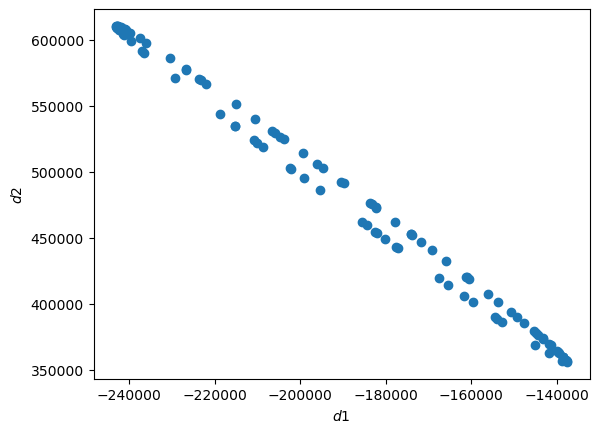

In [48]:
cst = 500
numpoints = 100
mX_try = 10
axis1_try = 0
axis2_try = 1
values_plane = eqn_of_plane_projection(500, numpoints, mX, R_obs_modelA_300[1],axis1_try,axis2_try)
plt.scatter(values_plane[:,0], values_plane[:,1])
plt.xlabel(r'$d$'+str(axis1_try+1))
plt.ylabel(r'$d$'+str(axis2_try+1))

## Series of plots to determine if fit is good.

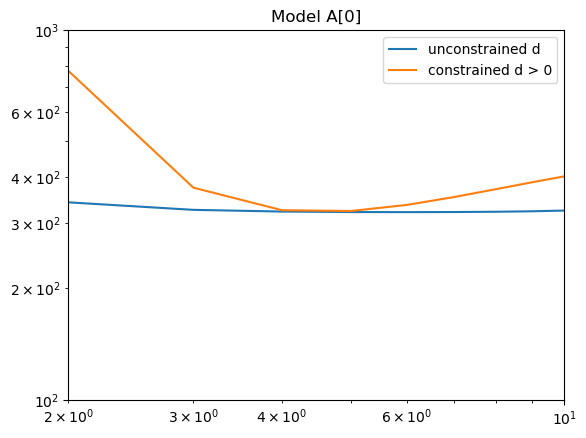

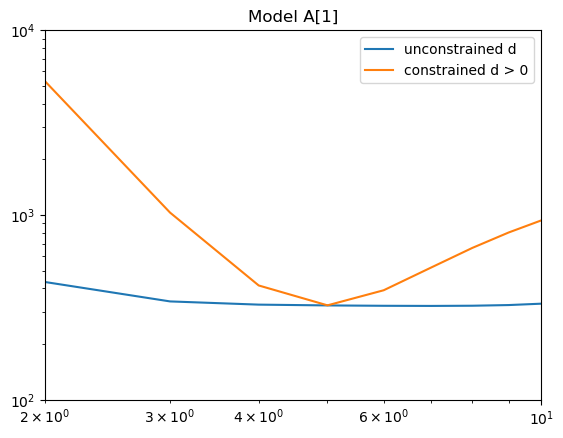

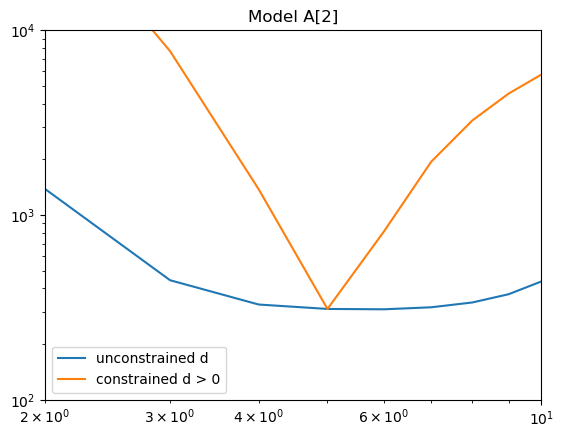

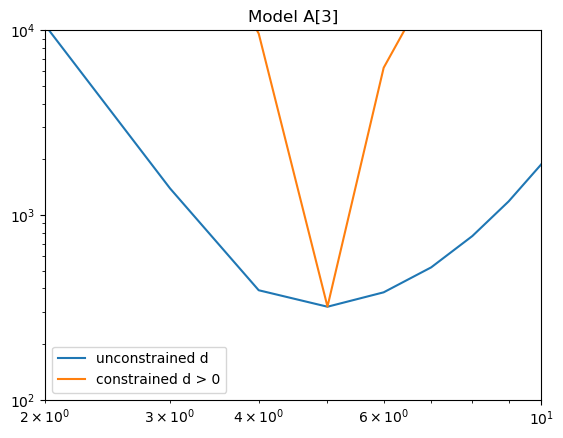

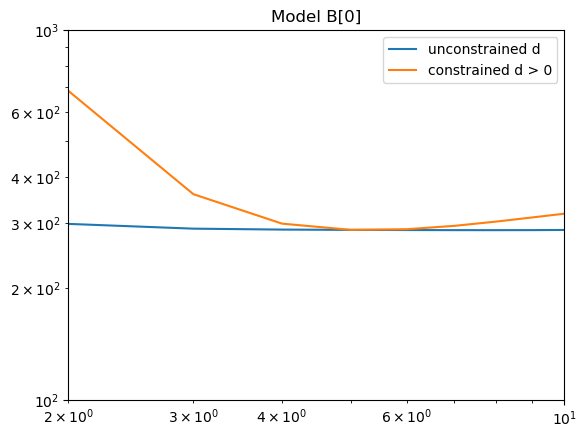

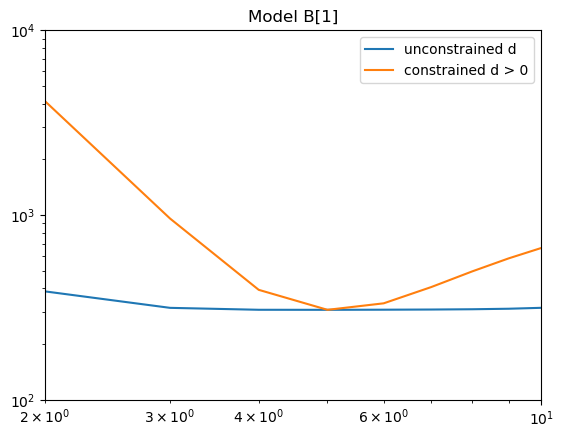

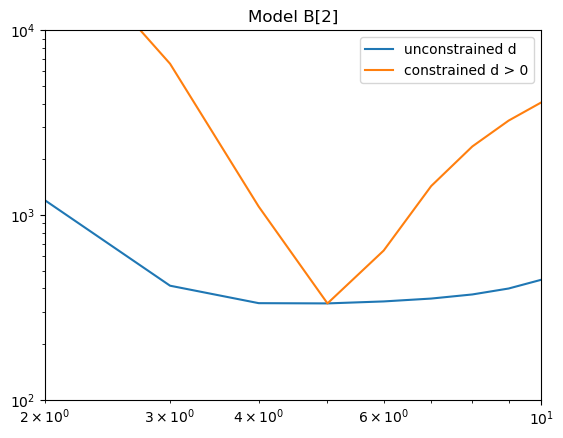

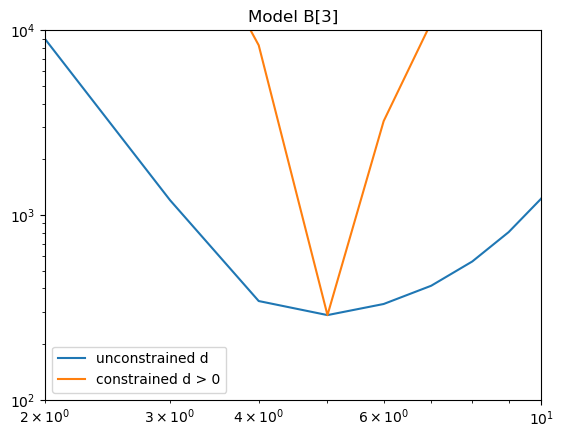

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[0])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[0]")
plt.ylim(1e2,1e3)
plt.xlim(2,10)
plt.savefig("modelA[0]_zoom.jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[1])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[1]")
plt.ylim(1e2,1e4)
plt.xlim(2,10)
plt.savefig("modelA[1]_zoom.jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[2])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[2]")
plt.ylim(1e2,1e4)
plt.xlim(2,10)
plt.savefig("modelA[2]_zoom.jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[3])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[3]")
plt.ylim(1e2,1e4)
plt.xlim(2,10)
plt.savefig("modelA[3]_zoom.jpg")
plt.show()


### B models

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[0])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[0]")
plt.ylim(1e2,1e3)
plt.xlim(2,10)
plt.savefig("modelB[0]_zoom.jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[1])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[1]")
plt.ylim(1e2,1e4)
plt.xlim(2,10)
plt.savefig("modelB[1]_zoom.jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[2])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[2]")
plt.ylim(1e2,1e4)
plt.xlim(2,10)
plt.savefig("modelB[2]_zoom.jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[3])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[3]")
plt.ylim(1e2,1e4)
plt.xlim(2,10)
plt.savefig("modelB[3]_zoom.jpg")
plt.show()

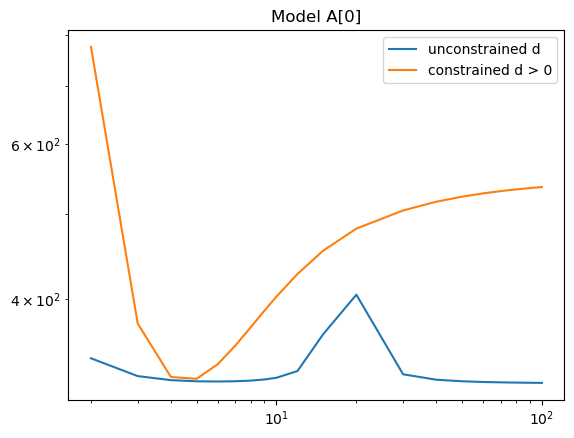

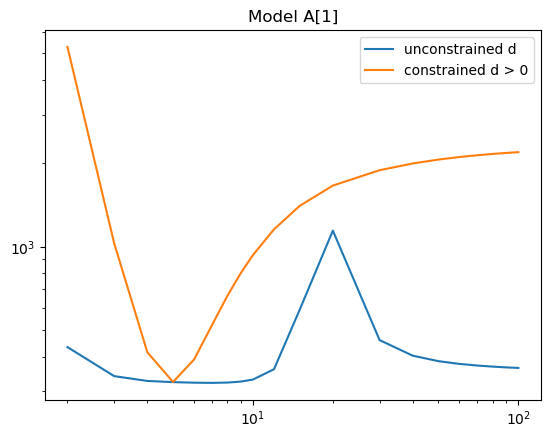

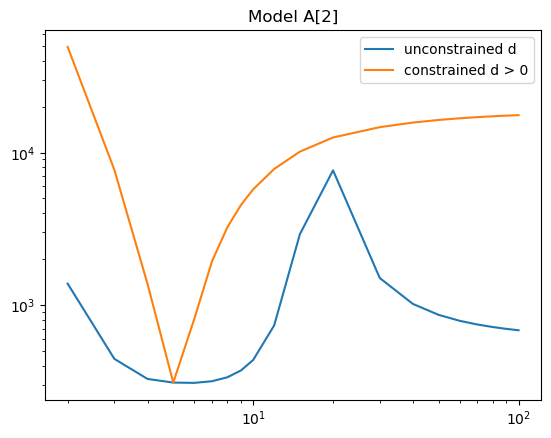

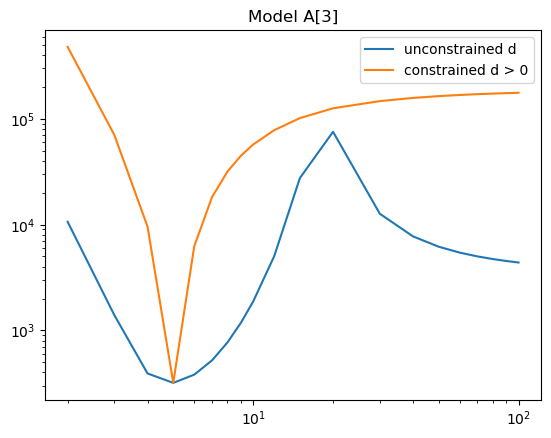

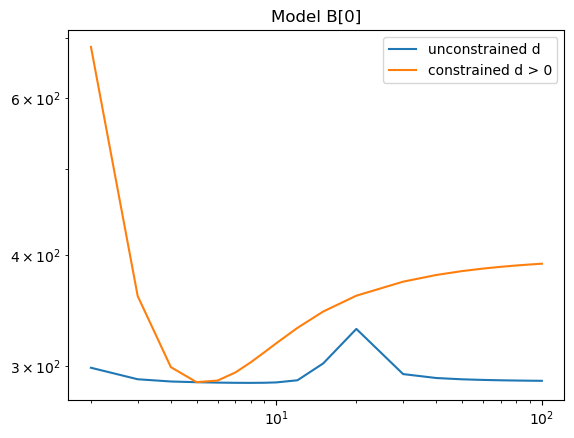

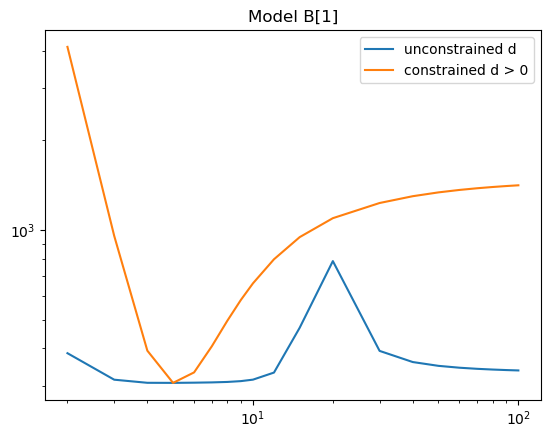

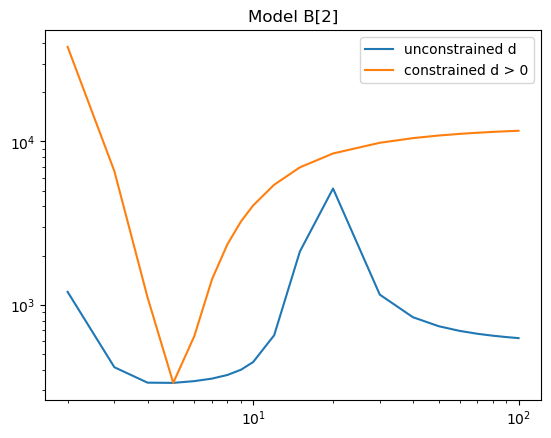

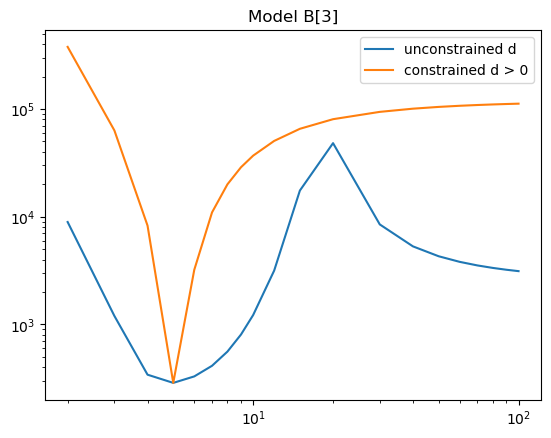

In [62]:
qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[0])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[0]")
#plt.ylim(1e2,1e3)
#plt.xlim(2,10)
plt.savefig("modelA[0].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[1])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[1]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.savefig("modelA[1].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[2])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[2]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.savefig("modelA[2].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelA_300[3])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model A[3]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.savefig("modelA[3].jpg")
plt.show()


### B models

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[0])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[0]")
#plt.ylim(1e2,1e3)
#plt.xlim(2,10)
plt.savefig("modelB[0].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[1])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[1]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.savefig("modelB[1].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[2])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[2]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.savefig("modelB[2].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_= fit_mX(R_obs_modelB_300[3])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.legend()
plt.title("Model B[3]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.savefig("modelB[3].jpg")
plt.show()

In [50]:
best_fit_mX(R_obs_modelA_300[2])
#best_fit_mX_constrained(R_obs_modelB_300[3])

(array([ 28944.25073732, -52939.01875537,  32060.90620232]),
 308.3635870404351,
 6)

In [63]:
print(best_fit_mX_constrained(R_obs_modelA_300[0]))
print(best_fit_mX_constrained(R_obs_modelA_300[1]))
print(best_fit_mX_constrained(R_obs_modelA_300[2]))
print(best_fit_mX_constrained(R_obs_modelA_300[3]))

(array([ 31.05960329,   0.        , 116.44834272]), 323.9651985875065, 5)
(array([ 293.93771979,    0.        , 1196.99256488]), 323.9469114351382, 5)
(array([ 1597.78777335,  3481.38588746, 10301.30148044]), 309.7632278746528, 5)
(array([ 33604.06106832,      0.        , 115735.18903072]), 318.9160411865966, 5)


In [64]:
print(best_fit_mX_constrained(R_obs_modelB_300[0]))
print(best_fit_mX_constrained(R_obs_modelB_300[1]))
print(best_fit_mX_constrained(R_obs_modelB_300[2]))
print(best_fit_mX_constrained(R_obs_modelB_300[3]))

(array([  0.        , 145.91525272,  25.76253461]), 288.04334929199166, 5)
(array([ 179.01435611, 1125.15799122,  390.9543633 ]), 306.34049155823516, 5)
(array([3276.82783457, 8247.91187956, 5036.06024808]), 331.840101057507, 5)
(array([29593.42161645, 89572.94430679, 47326.43121802]), 286.87871739571574, 5)


In [65]:
print(best_fit_mX(R_obs_modelA_300[0]))
print(best_fit_mX(R_obs_modelA_300[1]))
print(best_fit_mX(R_obs_modelA_300[2]))
print(best_fit_mX(R_obs_modelA_300[3]))

(array([-20378.05936148,  51787.87548122, -21992.99068892]), 320.52227799952834, 100)
(array([  6374.34249806, -12762.07272198,   6222.14228095]), 321.60608205881283, 7)
(array([ 28944.25073732, -52939.01875537,  32060.90620232]), 308.3635870404351, 6)
(array([ 35835.6654614 ,  -4605.31234757, 117507.19173615]), 318.4061009725925, 5)


In [66]:
print(best_fit_mX(R_obs_modelB_300[0]))
print(best_fit_mX(R_obs_modelB_300[1]))
print(best_fit_mX(R_obs_modelB_300[2]))
print(best_fit_mX(R_obs_modelB_300[3]))

(array([  744.34675587, -1400.21883208,   635.18699121]), 287.51244183447255, 8)
(array([ 179.01435614, 1125.15799118,  390.95436332]), 306.34049155823516, 5)
(array([3276.82783476, 8247.91187918, 5036.06024822]), 331.8401010575069, 5)
(array([29593.42161848, 89572.9443026 , 47326.43121963]), 286.8787173957156, 5)


In [68]:
np.max(R_obs_modelA_300[2])

12009.0

In [79]:
best_fit_mX(R_obs_modelA_300[3])

(array([22332.80797223, -2870.03338674, 73230.55159186]),
 318.40610097258985,
 5)

In [81]:
#Best-fits
mX = 1
print("The value of q(dstar) for model A0 is",qd_star(mX,R_obs_modelA_300[0])[1])
print("The value of q(dstar) for model A1 is",qd_star(mX,R_obs_modelA_300[1])[1])
print("The value of q(dstar) for model A2 is",qd_star(mX,R_obs_modelA_300[2])[1])
print("The value of q(dstar) for model A3 is",qd_star(mX,R_obs_modelA_300[3])[1])

print("The value of q(dstar) for model B0 is",qd_star(mX,R_obs_modelB_300[0])[1])
print("The value of q(dstar) for model B1 is",qd_star(mX,R_obs_modelB_300[1])[1])
print("The value of q(dstar) for model B2 is",qd_star(mX,R_obs_modelB_300[2])[1])
print("The value of q(dstar) for model B3 is",qd_star(mX,R_obs_modelB_300[3])[1])


The value of q(dstar) for model A0 is 340.38659541932725
The value of q(dstar) for model A1 is 617.9520597948103
The value of q(dstar) for model A2 is 3533.1597903515203
The value of q(dstar) for model A3 is 31140.33416760842
The value of q(dstar) for model B0 is 322.87389290698025
The value of q(dstar) for model B1 is 566.4363555050071
The value of q(dstar) for model B2 is 3517.646372839458
The value of q(dstar) for model B3 is 31391.047713928107


In [82]:
mX = 10
print("The value of q(dstar) for model A0 is",qd_star(mX,R_obs_modelA_300[0])[1])
print("The value of q(dstar) for model A1 is",qd_star(mX,R_obs_modelA_300[1])[1])
print("The value of q(dstar) for model A2 is",qd_star(mX,R_obs_modelA_300[2])[1])
print("The value of q(dstar) for model A3 is",qd_star(mX,R_obs_modelA_300[3])[1])

print("The value of q(dstar) for model B0 is",qd_star(mX,R_obs_modelB_300[0])[1])
print("The value of q(dstar) for model B1 is",qd_star(mX,R_obs_modelB_300[1])[1])
print("The value of q(dstar) for model B2 is",qd_star(mX,R_obs_modelB_300[2])[1])
print("The value of q(dstar) for model B3 is",qd_star(mX,R_obs_modelB_300[3])[1])


The value of q(dstar) for model A0 is 324.8570561490984
The value of q(dstar) for model A1 is 330.70214408975744
The value of q(dstar) for model A2 is 435.6456352109774
The value of q(dstar) for model A3 is 1872.9311638173424
The value of q(dstar) for model B0 is 287.8649624229593
The value of q(dstar) for model B1 is 314.09815131976336
The value of q(dstar) for model B2 is 445.2517420121109
The value of q(dstar) for model B3 is 1223.1306522055152


In [83]:
mX = 100
print("The value of q(dstar) for model A0 is",qd_star(mX,R_obs_modelA_300[0])[1])
print("The value of q(dstar) for model A1 is",qd_star(mX,R_obs_modelA_300[1])[1])
print("The value of q(dstar) for model A2 is",qd_star(mX,R_obs_modelA_300[2])[1])
print("The value of q(dstar) for model A3 is",qd_star(mX,R_obs_modelA_300[3])[1])

print("The value of q(dstar) for model B0 is",qd_star(mX,R_obs_modelB_300[0])[1])
print("The value of q(dstar) for model B1 is",qd_star(mX,R_obs_modelB_300[1])[1])
print("The value of q(dstar) for model B2 is",qd_star(mX,R_obs_modelB_300[2])[1])
print("The value of q(dstar) for model B3 is",qd_star(mX,R_obs_modelB_300[3])[1])


The value of q(dstar) for model A0 is 320.5222779995304
The value of q(dstar) for model A1 is 364.1836728643683
The value of q(dstar) for model A2 is 682.5637306104175
The value of q(dstar) for model A3 is 4380.877658434368
The value of q(dstar) for model B0 is 289.0372402780447
The value of q(dstar) for model B1 is 337.2653295225111
The value of q(dstar) for model B2 is 623.952968754387
The value of q(dstar) for model B3 is 3126.2966102256396


In [84]:
# Let's compare the d_star obtained.
print("dstar for model A0 is",qd_star(1,R_obs_modelA_300[0])[0])
print("dstar for model A0 is",qd_star(10,R_obs_modelA_300[0])[0])
print("dstar for model A0 is",qd_star(100,R_obs_modelA_300[0])[0])

dstar for model A0 is [-277944.03275866  947383.60540798 -727917.78708425]
dstar for model A0 is [ 1448.41549379 -3114.42580945  1338.96528782]
dstar for model A0 is [-12699.61868176  32274.23471898 -13706.04484295]


In [85]:
# Let's compare the d_star obtained.
print("dstar for model B0 is",qd_star(1,R_obs_modelB_300[0])[0])
print("dstar for model B0 is",qd_star(10,R_obs_modelB_300[0])[0])
print("dstar for model B0 is",qd_star(100,R_obs_modelB_300[0])[0])

dstar for model B0 is [-266886.43906968  912306.65955327 -703097.63337759]
dstar for model B0 is [  961.92731192 -1963.53607955   845.00403972]
dstar for model B0 is [-8100.46033202 21693.57857558 -9303.64843649]


In [86]:
## Try non-negative least squares (nnls)
qd_star_nnls(mX, R_obs_modelB_300[0])

(array([631.02184099, 390.39939475,   0.        ]), 391.10143686150826)

In [87]:
q_contour_pts(500.0,100,R_obs_modelA_300[1])

The value of q(dstar) is 364.1836728643683
[92627.87239771  3113.95391084   117.82358184]
500.0000000000018
499.9999999999972
500.0000000000754


array([[-151363.57665283,  380625.26462842, -161697.43636878],
       [-120981.59782319,  301072.47499077, -125120.00511466],
       [-118553.91893822,  301226.00643778, -127067.66901828]])

In [272]:
eqn_of_ellipsoid(5000.0, 2, 100, R_obs_modelA_300[3])

The value of q(dstar) is 2866.757308773414
4999.999999989859
4999.999999989495
The first 2 coordinates on ellipsoid are [[-13393260.19347437  42493183.061257   -20750175.61100347]
 [-13716889.62160534  43317740.82569677 -21116634.23988689]]


array([[-13393260.19347437,  42493183.061257  , -20750175.61100347],
       [-13716889.62160534,  43317740.82569677, -21116634.23988689]])

## Models C,D,E

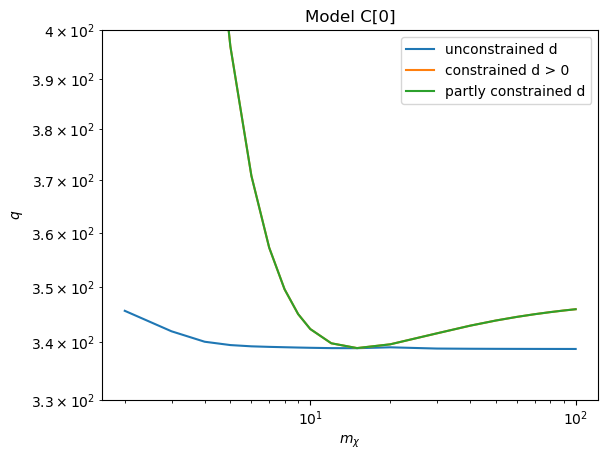

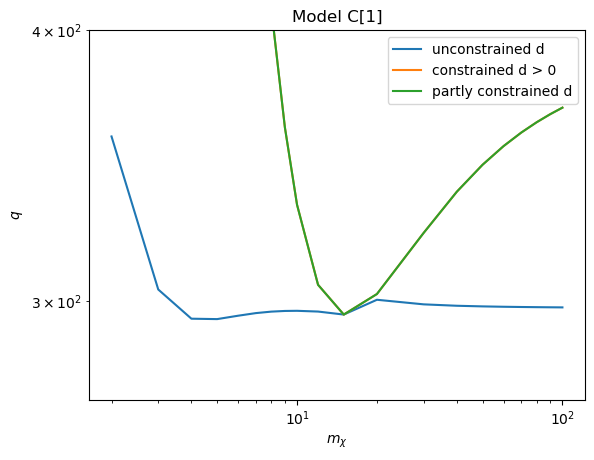

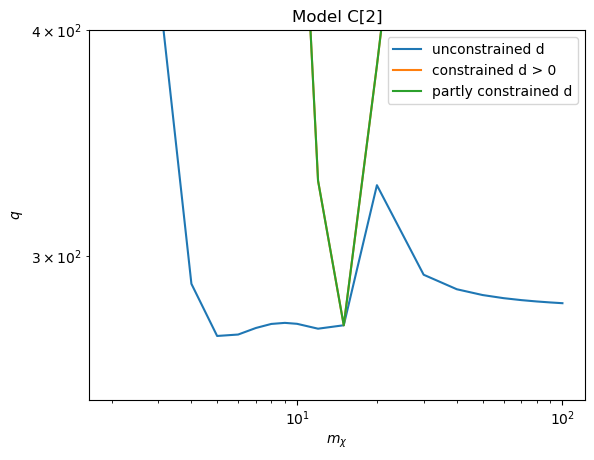

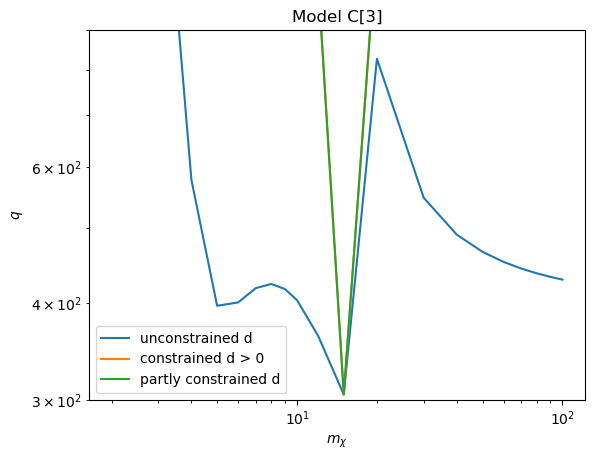

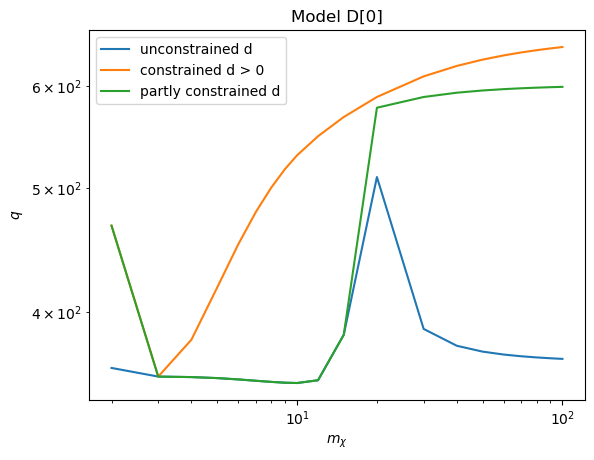

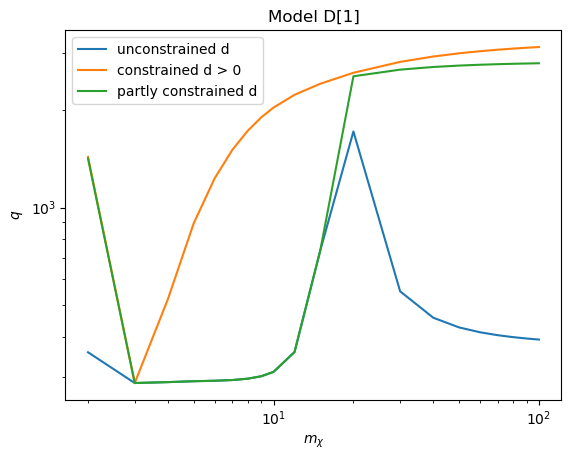

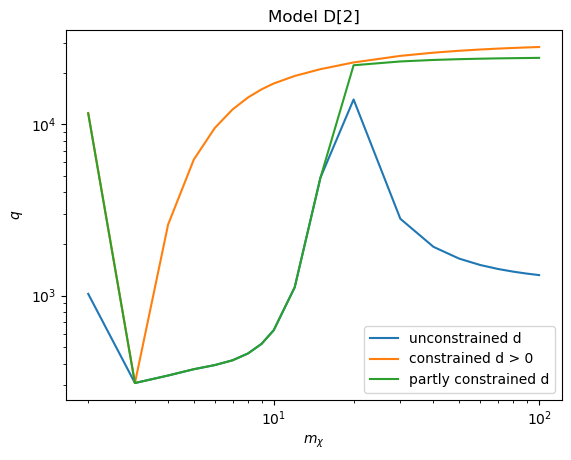

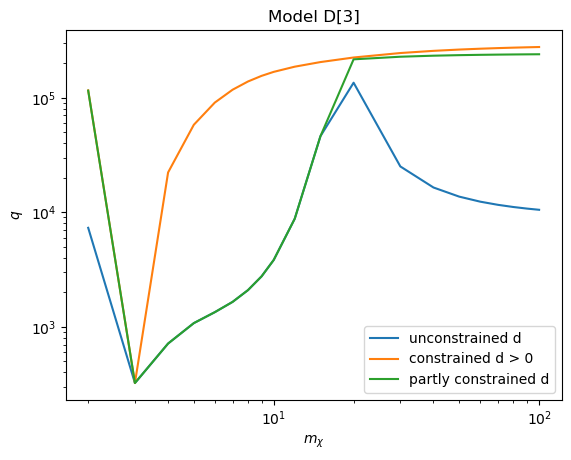

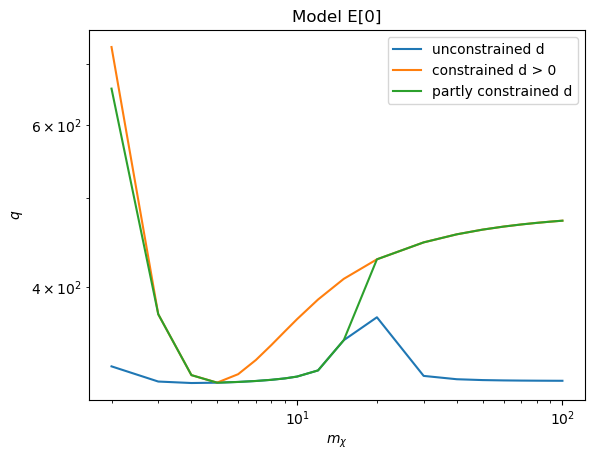

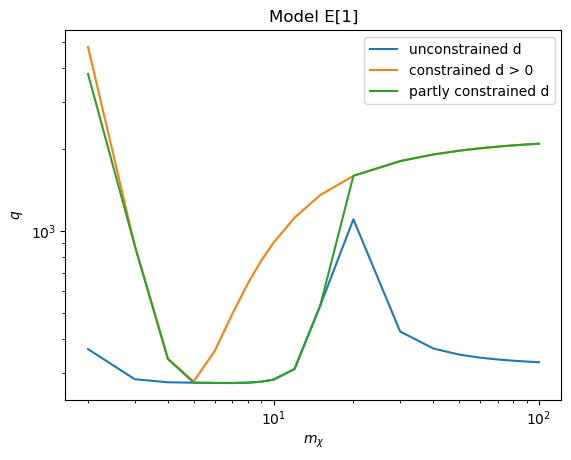

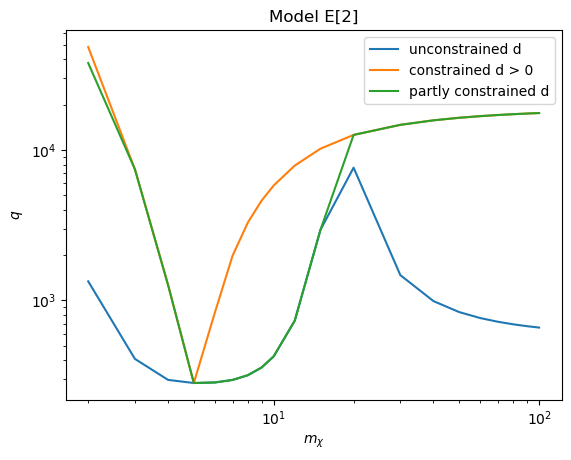

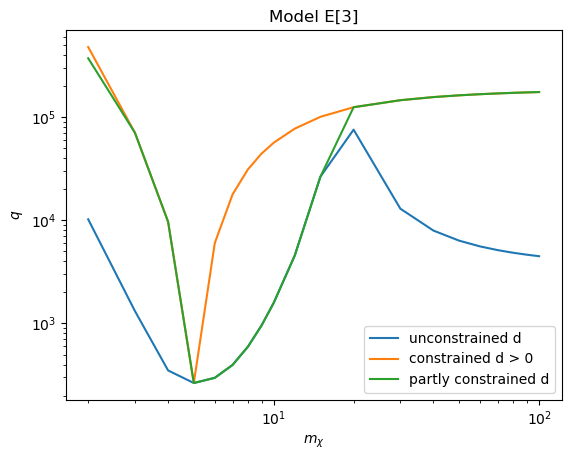

In [126]:
qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelC_300[0])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model C[0]")
plt.ylim(3.3e2,4e2)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelC[0].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelC_300[1])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model C[1]")
plt.ylim(2.7e2,4e2)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelC[1].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelC_300[2])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model C[2]")
plt.ylim(2.5e2,4e2)
#plt.xlim(2,10
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelC[2].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelC_300[3])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model C[3]")
plt.ylim(3e2,9e2)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelC[3].jpg")
plt.show()


### D models

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelD_300[0])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model D[0]")
#plt.ylim(1e2,1e3)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelD[0].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelD_300[1])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model D[1]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelD[1].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelD_300[2])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model D[2]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelD[2].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelD_300[3])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model D[3]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelD[3].jpg")
plt.show()

### E models

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelE_300[0])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model E[0]")
#plt.ylim(1e2,1e3)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelE[0].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelE_300[1])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model E[1]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelE[1].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelE_300[2])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model E[2]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelE[2].jpg")
plt.show()

qdstar_arr_uncons_, qdstar_arr_cons_, qdstar_arr_part_cons_= fit_mX(R_obs_modelE_300[3])

plt.loglog(mXlist,qdstar_arr_uncons_, label = "unconstrained d")
plt.loglog(mXlist,qdstar_arr_cons_,label = "constrained d > 0")
plt.loglog(mXlist,qdstar_arr_part_cons_,label = "partly constrained d")
plt.legend()
plt.title("Model E[3]")
#plt.ylim(1e2,1e4)
#plt.xlim(2,10)
plt.ylabel(r'$q$')
plt.xlabel(r'$m_\chi$')
plt.savefig("modelE[3].jpg")
plt.show()

In [127]:
## Best-fit values for model C (partly constrained d)
print(best_fit_mX_constrained_two_coeff(R_obs_modelC_300[0]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelC_300[1]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelC_300[2]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelC_300[3]))

(array([5.35729682e+01, 2.50036917e+02, 2.93639804e-08]), 339.0062815805404, 15)
(array([ 319.15531208, 2694.7164592 ,   46.49949683]), 295.6258033921053, 15)
(array([12685.23121308,  4817.36290744,  9851.24541324]), 274.8633583219772, 15)
(array([ 88564.77152488, 137482.69376242,  60996.97035741]), 304.81707608905134, 15)


In [128]:
## Best-fit values for model D (partly constrained d)
print(best_fit_mX_constrained_two_coeff(R_obs_modelD_300[0]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelD_300[1]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelD_300[2]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelD_300[3]))

(array([ 3530.23166696, -7331.28216741,  2970.89870672]), 352.4237511268191, 10)
(array([ 899.65294405,    5.66910132, 1145.41906119]), 287.4563789184328, 3)
(array([ 8944.76685962,   987.79596131, 10731.55868393]), 308.70950697504713, 3)
(array([76892.89118778, 35613.39337153, 97272.37306472]), 323.0513076462604, 3)


In [129]:
## Best-fit values for model E (partly constrained d)
print(best_fit_mX_constrained_two_coeff(R_obs_modelE_300[0]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelE_300[1]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelE_300[2]))
print(best_fit_mX_constrained_two_coeff(R_obs_modelE_300[3]))

(array([ 70.9883392 , -48.77868878, 121.20679332]), 314.28274650065845, 5)
(array([  6783.10640123, -13416.54011191,   6387.42656256]), 275.2685737256816, 7)
(array([ 2724.01688755,  1390.32287688, 10987.28144204]), 281.9279913691616, 5)
(array([ 33211.92608906,   1052.84988941, 115217.75075196]), 264.655797320734, 5)


In [83]:
## Best-fit values for model C (constrained d>0)
print(best_fit_mX_constrained(R_obs_modelC_300[0]))
print(best_fit_mX_constrained(R_obs_modelC_300[1]))
print(best_fit_mX_constrained(R_obs_modelC_300[2]))
print(best_fit_mX_constrained(R_obs_modelC_300[3]))

(array([ 53.57296819, 250.03691752,   0.        ]), 339.0062815805326, 15)
(array([ 319.15531225, 2694.71645882,   46.49949699]), 295.6258033921056, 15)
(array([12685.23121964,  4817.36289245,  9851.24541947]), 274.86335832197756, 15)
(array([ 88564.77154015, 137482.69372742,  60996.97037199]), 304.8170760890509, 15)


In [84]:
## Best-fit values for model D (constrained d>0)
print(best_fit_mX_constrained(R_obs_modelD_300[0]))
print(best_fit_mX_constrained(R_obs_modelD_300[1]))
print(best_fit_mX_constrained(R_obs_modelD_300[2]))
print(best_fit_mX_constrained(R_obs_modelD_300[3]))

(array([ 97.59777706,   0.        , 108.08548536]), 356.5167012414467, 3)
(array([ 899.65294401,    5.6691014 , 1145.41906116]), 287.4563789184328, 3)
(array([ 8944.76685928,   987.79596202, 10731.55868365]), 308.7095069750475, 3)
(array([76892.89118524, 35613.39337677, 97272.37306263]), 323.05130764626153, 3)


In [85]:
## Best-fit values for model E (constrained d>0)
print(best_fit_mX_constrained(R_obs_modelE_300[0]))
print(best_fit_mX_constrained(R_obs_modelE_300[1]))
print(best_fit_mX_constrained(R_obs_modelE_300[2]))
print(best_fit_mX_constrained(R_obs_modelE_300[3]))

(array([ 47.34698582,   0.        , 102.44172674]), 314.34022937643476, 5)
(array([ 375.2883396 ,    0.        , 1119.91488471]), 278.90601157650315, 5)
(array([ 2724.01688744,  1390.32287712, 10987.28144195]), 281.9279913691612, 5)
(array([ 33211.9260883 ,   1052.849891  , 115217.75075134]), 264.6557973207334, 5)


In [89]:
## Best-fit values for model C (unconstrained d)
print(best_fit_mX(R_obs_modelC_300[0]))
print(best_fit_mX(R_obs_modelC_300[1]))
print(best_fit_mX(R_obs_modelC_300[2]))
print(best_fit_mX(R_obs_modelC_300[3]))

(array([-3042.85562964, 10056.7078226 , -3954.37479776]), 338.8519993464166, 100)
(array([-7975.21623179, 18032.03413006, -6151.74386446]), 294.19914830033264, 5)
(array([-78294.84499286, 177074.92866983, -60142.9948825 ]), 271.1460216167594, 5)
(array([ 88564.77152488, 137482.69376242,  60996.97035741]), 304.8170760890516, 15)


In [87]:
## Best-fit values for model D (unconstrained d)
print(best_fit_mX(R_obs_modelD_300[0]))
print(best_fit_mX(R_obs_modelD_300[1]))
print(best_fit_mX(R_obs_modelD_300[2]))
print(best_fit_mX(R_obs_modelD_300[3]))

(array([ 3530.23166696, -7331.28216741,  2970.89870672]), 352.42375112681833, 10)
(array([ 899.65294405,    5.66910132, 1145.41906119]), 287.4563789184328, 3)
(array([ 8944.76685962,   987.79596131, 10731.55868393]), 308.70950697504713, 3)
(array([76892.89118778, 35613.39337153, 97272.37306472]), 323.05130764626193, 3)


In [88]:
## Best-fit values for model E (unconstrained d)
print(best_fit_mX(R_obs_modelE_300[0]))
print(best_fit_mX(R_obs_modelE_300[1]))
print(best_fit_mX(R_obs_modelE_300[2]))
print(best_fit_mX(R_obs_modelE_300[3]))

(array([-239.08236776,  575.02083774, -106.11021462]), 314.01918416843336, 4)
(array([  6783.10640123, -13416.54011191,   6387.42656256]), 275.2685737256811, 7)
(array([ 2724.01688755,  1390.32287688, 10987.28144204]), 281.9279913691615, 5)
(array([ 33211.92608906,   1052.84988941, 115217.75075196]), 264.65579732073263, 5)


## Useless

In [463]:
eqn_of_ellipsoid(500.0, 2, 100, R_obs[3])

The value of q(dstar) is 869.4708113988156


Exception: You cannot have contours q(d) < q(d_star). Please adjust your constant.

In [123]:
rate_mat(mX, R_obs[0])

array([[8.28136397e-02, 2.85488187e-07, 1.19045133e-12, ...,
        2.55536252e-01, 5.28983325e-07, 1.57387218e-12],
       [8.28136397e-02, 2.85488187e-07, 1.19045133e-12, ...,
        2.55536252e-01, 5.28983325e-07, 1.57387218e-12],
       [8.28136397e-02, 2.85488187e-07, 1.19045133e-12, ...,
        2.55536252e-01, 5.28983325e-07, 1.57387218e-12],
       ...,
       [8.28136397e-02, 2.85488187e-07, 1.19045133e-12, ...,
        2.55536252e-01, 5.28983325e-07, 1.57387218e-12],
       [8.28136397e-02, 2.85488187e-07, 1.19045133e-12, ...,
        2.55536252e-01, 5.28983325e-07, 1.57387218e-12],
       [8.28136397e-02, 2.85488187e-07, 1.19045133e-12, ...,
        2.55536252e-01, 5.28983325e-07, 1.57387218e-12]])

In [126]:
np.min(rate_mat(mX,R_obs[0]))

4.309201664439696e-13

In [258]:
whalff = np.diag(R_obs[1]**(-1/2))

In [269]:
mX=100
tilde_R_mX_trial = np.dot(whalff, rate_mat(mX, R_obs[1]))
tilde_R_obs_tri = np.matmul(whalff, R_obs[1])
tilde_pseudo_inv_trial = pseudo_inv(tilde_R_mX_trial)

u_tilde_tri,sigma_tilde_tri,v_tilde_transpose_tri = np.linalg.svd(np.sqrt(1.0)*tilde_pseudo_inv_trial)
P_tri = u_tilde_tri
D_tri = np.diag(1/(sigma_tilde_tri**2))
D_half_tri = np.sqrt(D_tri)
    
A_half_tri = np.dot(np.dot(P_tri,D_half_tri),P_tri.T)
v_vec_tri = np.dot(tilde_pseudo_inv_trial, tilde_R_obs_tri)

The matrix Sigma is [1.54122145e-01 4.65182114e-03 1.31878988e-03 1.08719576e-05
 2.39457098e-07]


In [283]:
q_approx(np.dot(np.linalg.inv(A_half_tri), np.array([0,1,0,0,0]))+ v_vec_tri,R_obs[1],rate_mat(mX, R_obs[1]))

323.6695747369517

In [311]:
np.dot(tilde_pseudo_inv_trial, tilde_R_mX_trial)

array([[ 1.00000000e+00,  8.66862138e-13,  7.24753590e-13,
        -1.19371180e-12,  4.34852154e-12],
       [-3.75166564e-12,  1.00000000e+00, -2.07478479e-12,
         4.06430445e-12, -1.72803993e-11],
       [ 2.79953838e-12,  1.43529633e-12,  1.00000000e+00,
        -2.50111043e-12,  1.77351467e-11],
       [ 5.15143483e-13, -8.41993142e-13,  3.55271368e-15,
         1.00000000e+00, -5.57065505e-12],
       [ 6.29496455e-14,  4.67403893e-14,  3.59712260e-14,
        -1.04583009e-13,  1.00000000e+00]])

In [252]:
np.linalg.norm(u_tilde_tri[:,2])

1.0000000000000004

In [273]:
d_star_alpha_zero_mX_tri = np.dot(tilde_pseudo_inv_trial,tilde_R_obs_tri)

q_approx(d_star_alpha_zero_mX_tri,R_obs[1],rate_mat(mX, R_obs[1]))

322.66957473692884

In [285]:
blabla = eqn_of_ellipsoid(600.0, 2, 100, R_obs[1])

shape of R_obs is (300,)
The matrix Sigma is [1.54122145e-01 4.65182114e-03 1.31878988e-03 1.08719576e-05
 2.39457098e-07]
v_vec is [ -733979.23929257  2943138.77623979 -3042028.21605043  1020834.83316483
  -101202.92895768]
first term is [  3472395.44948541 -13268222.98961506  12874557.30363001
  -3715637.79171778    273583.76764347]
basis check is 922.6695747326219
[  2738416.21019284 -10325084.21337527   9832529.08757957
  -2694802.95855295    172380.83868579]
q  922.6695747600252
922.6695747600252
922.6695747359512


In [293]:
np.dot(tilde_pseudo_inv_trial,np.zeros((1,5)))

ValueError: shapes (5,300) and (1,5) not aligned: 300 (dim 1) != 1 (dim 0)

In [197]:
rate_mat(mX, R_obs[0])

array([[0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       ...,
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625]])

In [238]:
mI[(1,(-4,0))].writeMcalI("I.hdf5", "1/4/0", alt_type=None)

('Ilvq_mean__2', 'Ilvq_sdev__2')

In [237]:

dmModel_try = dict(mX=1*MeV, fdm_n=(1,(-4,0)), mSM=mElec, DeltaE=4.03*eV)
mII = vsdm.McalI(Vdict, Qdict, dmModel_try, 
                                    mI_shape=(ellMax+1, nvMax+1,nqMax+1),center_Z2=True, 
                                      use_gvar=False, do_mcalI=False)
blo = mII.importMcalI("I.hdf5", "1/4/0", d_pair=['Ilvq_mean'])

ERROR! Session/line number was not unique in database. History logging moved to new session 20


TypeError: 'tuple' object does not support item assignment

In [ ]:
blo

In [245]:
mII.importMcalI("I.hdf5", "1/4/0", d_pair=['Ilvq_mean','Ilvq_sdev'])

TypeError: 'tuple' object does not support item assignment

In [255]:
rate_mat(100, R_obs[1])

array([[0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       ...,
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625],
       [0.08281364, 0.0610632 , 0.0656971 , 0.10577029, 0.25553625]])